In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [104]:
df = pd.read_csv('historyprice.csv', parse_dates=True, index_col='Date')

In [105]:
df.head()

,Prev Close,OPEN,HIGH,LOW,Last Price,close,Average Price,Total Traded Quantity,Turnover,No. of Trades,Deliverable Qty,% Dly Qt to Traded Qty
Date,,,,,,,,,,,,
2020-12-17,2814.20,2811.00,2853.70,2805.00,2848.70,2838.20,2823.94,2863460,8.086237e+09,121983,1423130,49.7
2020-12-18,2838.20,2868.00,2898.00,2846.20,2851.95,2861.00,2873.74,6076692,1.746284e+10,178840,2436219,40.09
2020-12-21,2861.00,2861.00,2886.50,2785.00,2810.00,2820.15,2853.21,2705195,7.718476e+09,141821,887083,32.79
2020-12-22,2820.15,2834.00,2883.65,2818.65,2870.65,2872.50,2848.13,2881737,8.207569e+09,158517,1123581,38.99
2020-12-23,2872.50,2876.05,2919.00,2865.45,2907.15,2908.75,2904.67,2790988,8.106912e+09,125341,947547,33.95


In [106]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 496 entries, 2020-12-17 to 2022-12-07
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Prev Close              496 non-null    float64
 1   OPEN                    496 non-null    float64
 2   HIGH                    496 non-null    float64
 3   LOW                     496 non-null    float64
 4   Last Price              496 non-null    float64
 5   close                   496 non-null    float64
 6   Average Price           496 non-null    float64
 7   Total Traded Quantity   496 non-null    int64  
 8   Turnover                496 non-null    float64
 9   No. of Trades           496 non-null    int64  
 10  Deliverable Qty         496 non-null    object 
 11  % Dly Qt to Traded Qty  496 non-null    object 
dtypes: float64(8), int64(2), object(2)
memory usage: 50.4+ KB


<AxesSubplot:xlabel='Date'>

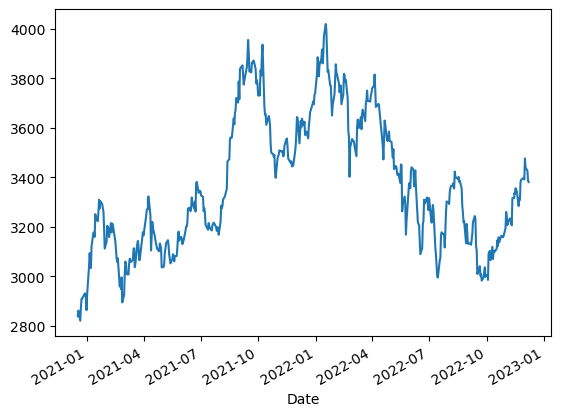

In [107]:
df['close'].plot()

In [108]:
len(df)

496

In [109]:
tcs_close = df['close']

In [110]:
tcs_close.reset_index(drop=True,inplace=True)
tcs_close.shape

(496,)

In [111]:
tcs_close = pd.DataFrame(tcs_close)
tcs_close.head()

,close
0,2838.20
1,2861.00
2,2820.15
3,2872.50
4,2908.75


In [112]:
train = tcs_close.iloc[:480]
test = tcs_close.iloc[480:]

In [113]:
from sklearn.preprocessing import MinMaxScaler

In [114]:
scaler = MinMaxScaler()

In [115]:
scaler.fit(train)

MinMaxScaler()

In [116]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [117]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

## Creating the Model

In [118]:
test.shape

(16, 1)

In [119]:
help(TimeseriesGenerator)

Help on class TimeseriesGenerator in module keras.preprocessing.sequence:

class TimeseriesGenerator(keras.utils.data_utils.Sequence)
 |  TimeseriesGenerator(data, targets, length, sampling_rate=1, stride=1, start_index=0, end_index=None, shuffle=False, reverse=False, batch_size=128)
 |  
 |  Utility class for generating batches of temporal data.
 |  
 |  Deprecated: `tf.keras.preprocessing.sequence.TimeseriesGenerator` does not
 |  operate on tensors and is not recommended for new code. Prefer using a
 |  `tf.data.Dataset` which provides a more efficient and flexible mechanism for
 |  batching, shuffling, and windowing input. See the
 |  [tf.data guide](https://www.tensorflow.org/guide/data) for more details.
 |  
 |  This class takes in a sequence of data-points gathered at
 |  equal intervals, along with time series parameters such as
 |  stride, length of history, etc., to produce batches for
 |  training/validation.
 |  
 |  Arguments:
 |      data: Indexable generator (such as li

In [120]:
length = 16
batch_size = 32
generator = TimeseriesGenerator(scaled_train, scaled_train, length = length, batch_size=batch_size)
# Will create an object with train - length and last 16 values will be predicted and validated

In [121]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, Dropout

In [122]:
n_features = 1

In [123]:
# Get initial weights
init_weights = model.get_weights()

In [124]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                      strides=1,
                      activation="relu",
                      padding='causal',
                      input_shape=[length, n_features]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


In [125]:
tf.keras.backend.clear_session()

# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history = model.fit_generator(generator, epochs=100, callbacks=[lr_schedule])

Epoch 1/100


C:\Users\vijai\AppData\Local\Temp\ipykernel_11300\1333944779.py:14: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator, epochs=100, callbacks=[lr_schedule])


15/15 [==============================] - 6s 22ms/step - loss: 0.2410 - lr: 1.0000e-08
Epoch 2/100
15/15 [==============================] - 0s 21ms/step - loss: 0.2145 - lr: 1.1220e-08
Epoch 3/100
15/15 [==============================] - 0s 21ms/step - loss: 0.2139 - lr: 1.2589e-08
Epoch 4/100
15/15 [==============================] - 0s 21ms/step - loss: 0.2077 - lr: 1.4125e-08
Epoch 5/100
15/15 [==============================] - 0s 22ms/step - loss: 0.2140 - lr: 1.5849e-08
Epoch 6/100
15/15 [==============================] - 0s 22ms/step - loss: 0.2054 - lr: 1.7783e-08
Epoch 7/100
15/15 [==============================] - 0s 22ms/step - loss: 0.2034 - lr: 1.9953e-08
Epoch 8/100
15/15 [==============================] - 0s 22ms/step - loss: 0.1994 - lr: 2.2387e-08
Epoch 9/100
15/15 [==============================] - 0s 21ms/step - loss: 0.1910 - lr: 2.5119e-08
Epoch 10/100
15/15 [==============================] - 0s 21ms/step - loss: 0.1897 - lr: 2.8184e-08
Epoch 11/100
15/15 [===========

(1e-08, 0.001, 0.0, 100.0)

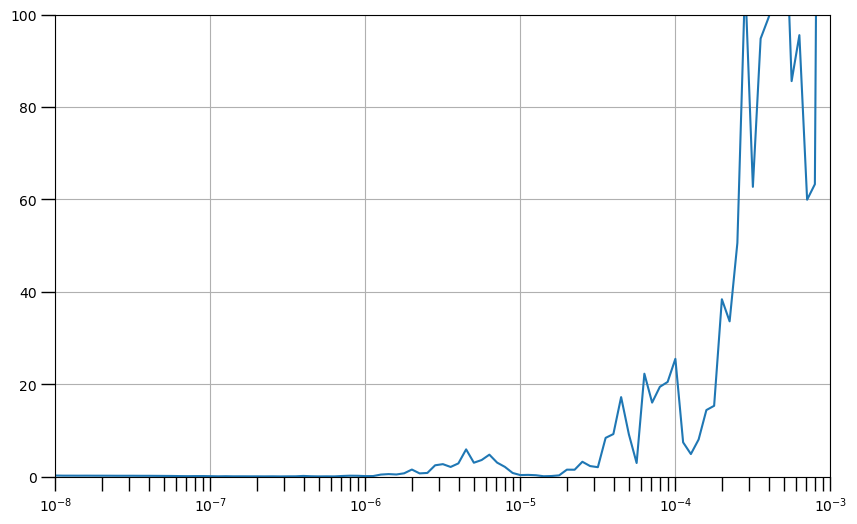

In [127]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 100])

In [128]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Reset the weights
model.set_weights(init_weights)

In [129]:
# Set the learning rate
learning_rate = 2.8184e-7
# Set the optimizer 
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [130]:
model.fit_generator(generator, epochs=100)

Epoch 1/100


C:\Users\vijai\AppData\Local\Temp\ipykernel_11300\3714150873.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator, epochs=100)


15/15 [==============================] - 6s 23ms/step - loss: 0.0045 - mae: 0.0747
Epoch 2/100
15/15 [==============================] - 0s 23ms/step - loss: 0.0048 - mae: 0.0811
Epoch 3/100
15/15 [==============================] - 0s 22ms/step - loss: 0.0041 - mae: 0.0740
Epoch 4/100
15/15 [==============================] - 0s 22ms/step - loss: 0.0045 - mae: 0.0784
Epoch 5/100
15/15 [==============================] - 0s 23ms/step - loss: 0.0042 - mae: 0.0748
Epoch 6/100
15/15 [==============================] - 0s 23ms/step - loss: 0.0043 - mae: 0.0772
Epoch 7/100
15/15 [==============================] - 0s 22ms/step - loss: 0.0051 - mae: 0.0836
Epoch 8/100
15/15 [==============================] - 0s 23ms/step - loss: 0.0057 - mae: 0.0871
Epoch 9/100
15/15 [==============================] - 0s 22ms/step - loss: 0.0050 - mae: 0.0838
Epoch 10/100
15/15 [==============================] - 0s 23ms/step - loss: 0.0046 - mae: 0.0771
Epoch 11/100
15/15 [==============================] - 0s 23ms

In [131]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 16, 64)            256       
                                                                 
 lstm (LSTM)                 (None, 16, 64)            33024     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 30)                1950      
                                                                 
 dense_1 (Dense)             (None, 10)                310       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
 lambda (Lambda)             (None, 1)                 0

In [132]:
losses = pd.DataFrame(model.history.history)

<AxesSubplot:>

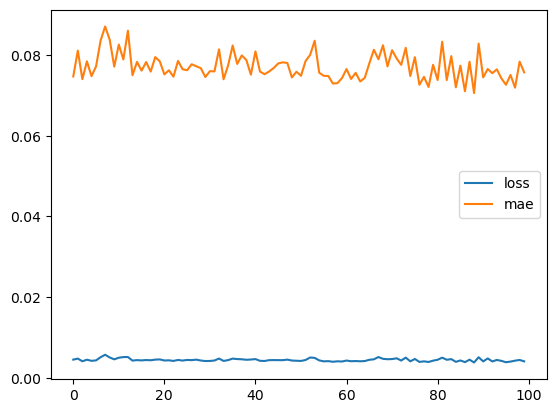

In [133]:
losses.plot()

## Evaluate test set

In [134]:
first_eval_batch = scaled_train[-length:] # picks last 16 values in train set

In [135]:
first_eval_batch

array([[0.28486239],
       [0.285196  ],
       [0.28127606],
       [0.28615513],
       [0.31109258],
       [0.36659716],
       [0.35158465],
       [0.32243536],
       [0.33131776],
       [0.34491243],
       [0.33019183],
       [0.32151793],
       [0.41351126],
       [0.41351126],
       [0.42981651],
       [0.42739783]])

In [136]:
first_eval_batch = first_eval_batch.reshape((1, length, 1))

In [137]:
first_eval_batch

array([[[0.28486239],
        [0.285196  ],
        [0.28127606],
        [0.28615513],
        [0.31109258],
        [0.36659716],
        [0.35158465],
        [0.32243536],
        [0.33131776],
        [0.34491243],
        [0.33019183],
        [0.32151793],
        [0.41351126],
        [0.41351126],
        [0.42981651],
        [0.42739783]]])

In [138]:
model.predict(first_eval_batch) #first prediction after train set which is first value of test

1/1 [==============================] - 1s 1s/step


array([[0.428268]], dtype=float32)

In [139]:
scaled_test[0]

array([0.44637198])

In [140]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1,length,n_features))

for i in range(len(test)):
    # Get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    #store prediction
    test_predictions.append(current_pred)
    
    #update batch to include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
                                

1/1 [==============================] - 0s 28ms/step


In [141]:
test_predictions

[array([0.428268], dtype=float32),
 array([0.43895772], dtype=float32),
 array([0.4473153], dtype=float32),
 array([0.45377007], dtype=float32),
 array([0.45893076], dtype=float32),
 array([0.46341023], dtype=float32),
 array([0.4686387], dtype=float32),
 array([0.4723972], dtype=float32),
 array([0.47444686], dtype=float32),
 array([0.47594038], dtype=float32),
 array([0.4770004], dtype=float32),
 array([0.47675154], dtype=float32),
 array([0.47538796], dtype=float32),
 array([0.47542608], dtype=float32),
 array([0.47469866], dtype=float32),
 array([0.4738354], dtype=float32)]

In [142]:
true_predictions = scaler.inverse_transform(test_predictions)

In [143]:
true_predictions

array([[3333.64331471],
       [3346.46030747],
       [3356.48105126],
       [3364.22031545],
       [3370.40798199],
       [3375.77886396],
       [3382.0477873 ],
       [3386.55425265],
       [3389.01178866],
       [3390.80251145],
       [3392.07346224],
       [3391.77509182],
       [3390.14016485],
       [3390.18586733],
       [3389.31369665],
       [3388.27865502]])

In [144]:
test['predictions'] = true_predictions

C:\Users\vijai\AppData\Local\Temp\ipykernel_11300\349349345.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['predictions'] = true_predictions


In [145]:
test

,close,predictions
480,3355.35,3333.643315
481,3349.00,3346.460307
482,3343.45,3356.481051
483,3283.50,3364.220315
484,3314.95,3370.407982
485,3308.30,3375.778864
486,3380.15,3382.047787
487,3389.65,3386.554253
488,3395.25,3389.011789
489,3397.35,3390.802511


<AxesSubplot:>

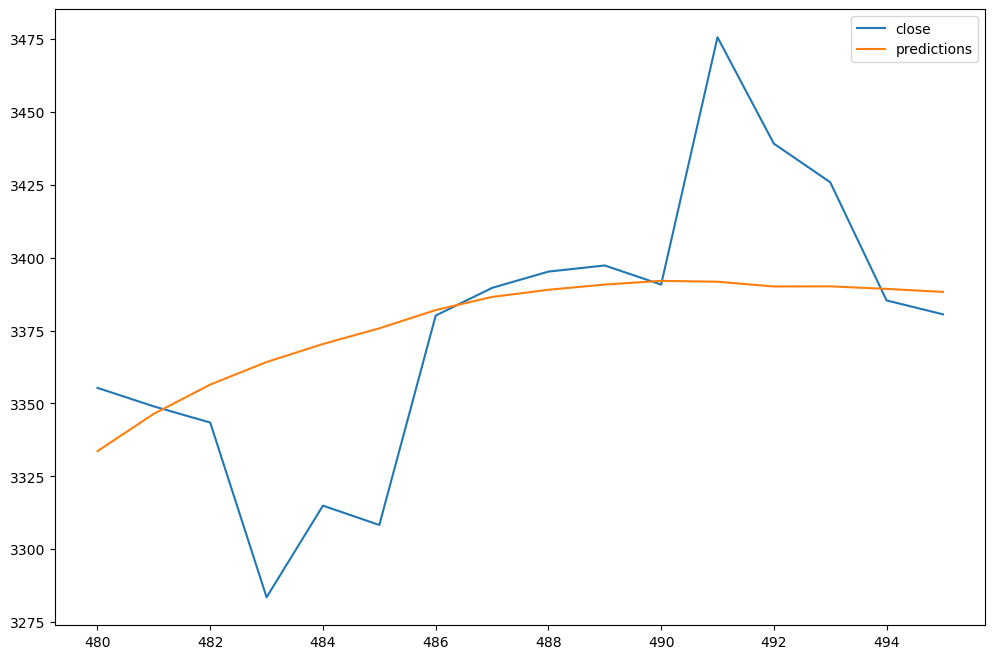

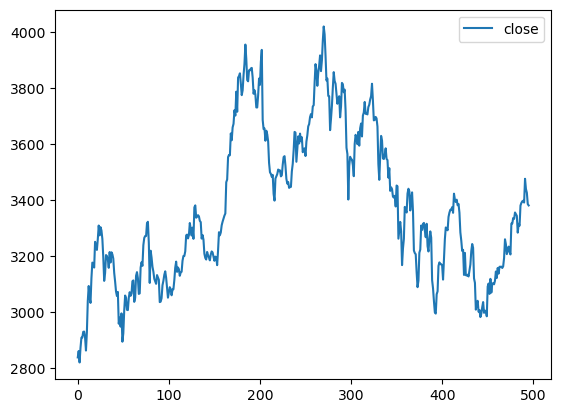

In [146]:
test.plot(figsize=(12,8))
tcs_close.plot()

## Let us create Full Model

In [ ]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(tcs_close)

In [ ]:
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length = length, batch_size=32)

In [ ]:
model = Sequential()

model.add(SimpleRNN(30,input_shape=(length,n_features)))
model.add(Dropout(rate=0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

In [ ]:
model.fit_generator(generator, epochs=10, shuffle=False)

In [ ]:
full_model_losses = pd.DataFrame(model.history.history)
full_model_losses.plot()

In [ ]:
forecast = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1,length,n_features))

for i in range(20):
    #get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    #store prediction
    forecast.append(current_pred)
    
    #update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [ ]:
forecast = scaler.inverse_transform(forecast)

In [ ]:
forecast

In [ ]:
forecast.flatten()

In [ ]:
df_array = np.array(tcs_close)
df_array

In [ ]:
full_data = pd.DataFrame(np.concatenate((df_array.flatten(), forecast.flatten())))

In [ ]:
full_data.plot()

## LSTM Model

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=2)

In [ ]:
length

In [ ]:
scaled_test.shape

In [ ]:
length = 15
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=32)

validation_generator = TimeseriesGenerator(scaled_test,scaled_test, length=length, batch_size=32)

In [ ]:
model = Sequential()

model.add(LSTM(30,input_shape=(length,n_features)))
model.add(Dropout(rate=0.2))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

In [ ]:
model.fit_generator(generator,epochs=20,validation_data=validation_generator,callbacks=[early_stop],shuffle=False)

In [ ]:
losses = pd.DataFrame(model.history.history)
losses.plot()

In [ ]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1,length,n_features))

for i in range(len(test)):
    # Get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    #store prediction
    test_predictions.append(current_pred)
    
    #update batch to include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [ ]:
true_predictions = scaler.inverse_transform(test_predictions)
test['LSTM_predictions'] = true_predictions
test.plot(figsize=(12,8))

In [ ]:
forecast = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1,length,n_features))

for i in range(15):
    #get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    #store prediction
    forecast.append(current_pred)
    
    #update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [ ]:
forecast = scaler.inverse_transform(forecast)

In [ ]:
full_data = pd.DataFrame(np.concatenate((df_array.flatten(), forecast.flatten())))

In [ ]:
full_data.plot()

In [ ]:
forecast

In [ ]:
full_data.tail(30)

## FB Prophet model

In [ ]:
df.reset_index(inplace=True)

In [ ]:
data = df[['Date','close']]

In [ ]:
data.head()

In [ ]:
from fbprophet import Prophet
m = Prophet(changepoint_prior_scale=0.15, daily_seasonality = True) # The prophet class model
m.fit(data) # fit the model using all data

In [ ]:
future = m.make_future_dataframe(periods=21) # We need to specify the number of days in future
prediction = m.predict(future)
m.plot(prediction)
plt.title("Prediction of the Google Stock Price using the Prophet")
plt.xlabel("Date")
plt.ylabel("Close Stock Price")
plt.show()

In [ ]:
m.plot_components(prediction)
plt.show()